In [1]:
from TRIOMA.tools.Extractors.PAV import Component,Fluid,Membrane, Geometry
import numpy as np 
import TRIOMA.tools.correlations as corr
import TRIOMA.tools.materials as materials
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.lines as mlines
from TRIOMA.tools.BreedingBlanket import BreedingBlanket

This analysis is a sweep on two parameters, in which the efficiency evaluated with the nodal model and the analytical efficiency are compared together, and the relative error in percentage is given. First we define the d_hyd_v, the first sweep vector. This is going to be sweeped against all others (otherwise the analysis would be very long if we sweep all vectors against each other). Then we define a vector of vectors to sweep. A str_v_vec is used in the "update_attribute" method to indicate which attribute is going to be updated, corresponding with the vector that is sweeped in the loop. The Fluid_v_bool vector is used in this code to check if the update attribute must be used for the Component class or the Component.fluid class. The same happens for the solid_v_bool. Color vectors will be used after for plotting contours. Eff_v_vec is used then to store the results.

In [2]:
##Define sweep vectors
color_vector = ["red", "blue", "green", "yellow", "purple", "orange"]
N_vec=50
d_hyd_v=np.logspace(np.log10(20.5E-3),np.log10(20E-2),N_vec)
T_vec=np.linspace(800,1000,N_vec)
U0_vec=np.linspace(1,5,N_vec)
# str_v_vec=['T','U0','Solubility','c_in',"thick","K_S","k_d","k_r"]
variables = {'T' : 'Temperature [K]', 'U0' : 'Velocity [m/s]', 'Solubility' : 'Solubility [mol/m^3]', 'c_in' : 'Concentration [mol/m^3]', 'thick' : 'Thickness [m]', 'K_S' : 'Partition Coefficient', 'k_d' : 'Desorption Rate [1/s]', 'k_r' : 'Reaction Rate [1/s]'}
c_in_vec=np.logspace(-6,-1,N_vec)
D_vec=np.logspace(-10,-8,N_vec)
thick_vec=np.logspace(-3,-1,N_vec)
K_S_vec=np.logspace(-3,-1,N_vec)
k_d_vec=np.logspace(2,6,N_vec)
k_r_vec=np.logspace(2,6,N_vec)
solubility_vec=np.logspace(-3,-1,N_vec)
v_vec=np.array([T_vec, U0_vec, solubility_vec, c_in_vec,  thick_vec, K_S_vec])
eff_v_vec=np.array([])
fluid_v_bool=np.array([True , True , True ,False,False,False,False,False,False])
solid_v_bool=np.array([False, False, False,False,True ,True ,True ,True ,True ])

Here variables for the Breeding Blanket class are defined. 

In [3]:
#Define other HX constraints

T_hot_prim=900
T_hot_sec=838
T_cold_prim=800
T_cold_sec=581
T_sec_ave=(T_hot_sec+T_cold_sec)/2
rho_sec=2263.628-0.636*T_sec_ave
mu_sec=0.075439-2.77E-4*(T_sec_ave-273.15)+3.49E-7*(T_sec_ave-273.15)**2-1.474E-10*(T_sec_ave-273.15)**3
k_sec=0.45
cp_sec=1396.044+0.172*(T_sec_ave)
N_HX=3
Q=1E9
m_in_sec=Q/(cp_sec*(T_hot_sec-T_cold_sec))

Empty arrays to store results with the append method are defined, and the double sweep takes place. In each iteration, the same component is defined and then one attribute is changed according to the sweep. Then color map plots are displayed, with additional isovariable contours.  

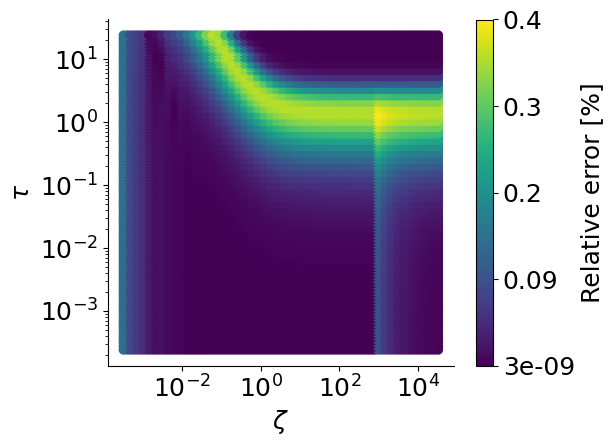

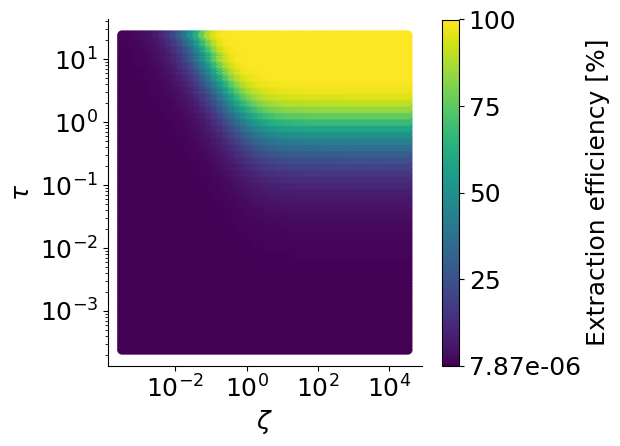

In [4]:
##set big font 
plt.rcParams.update({'font.size': 18})
d_hyd=25.4E-3
# D_f_vec=np.logspace(-10,-5,N_vec)
D_s_vec=np.logspace(-12,-4,N_vec)
L_vec=np.logspace(-1,4,N_vec)
Zeta_v=np.array([])
tau_v=np.array([])
res_vec=np.array([])
eff_v=np.array([])
for j,L in enumerate(L_vec):
        T=800
        for D_s in D_s_vec:
                mat=materials.Flibe(T)
                flibe=Fluid(T=T, Solubility=mat.Solubility, MS=False,D=1E-9, d_Hyd=d_hyd ,mu=mat.mu,rho=mat.rho,U0=1,k=mat.k,
                    cp=mat.cp)
                geom_PAV=Geometry(L=L,D=d_hyd,thick=2.1E-3,n_pipes=1)
                c0=1E-2
                Steel = Membrane( T=T,
                        D=D_s,
                        thick=2.1E-3,
                        K_S=4.41E-3,
                        k_d=1E6,
                        k_r=1E6,k=21)
                PAV = Component(c_in=c0, geometry=geom_PAV,eff=0.5, fluid=flibe, membrane=Steel)
                PAV.fluid.k_t=None
                PAV.get_adimensionals()
                PAV.get_efficiency(plotvar=False)
                PAV.analytical_efficiency()
                out_flux=(PAV.c_in*(1-PAV.eff)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                eff_v=np.append(eff_v, PAV.eff_an*100)
                res_vec=np.append(res_vec, abs(PAV.eff-PAV.eff_an)/PAV.eff_an)
                Zeta_v=np.append(Zeta_v, PAV.zeta)
                tau_v=np.append(tau_v, PAV.tau)
                # print("p_in",(PAV.c_in/PAV.fluid.Solubility)**2)
                ## delete flibe steel geom and PAV
                del flibe
                del Steel
                del geom_PAV
                del PAV
plt.figure(1)
plt.yscale('log')
plt.xscale('log')
plt.gca().spines['right'].set_visible(False)   
plt.gca().spines['top'].set_visible(False)
x = np.logspace(np.log10(min(Zeta_v[:])), np.log10(max(Zeta_v[:])), num=100)
y = np.logspace(np.log10(min(tau_v[:])), np.log10(max(tau_v[:])), num=100)
X, Y = np.meshgrid(x, y)
Z = griddata((Zeta_v, tau_v), (res_vec)*100, (X, Y), method='nearest')
Z_eff=griddata((Zeta_v, tau_v), eff_v, (X, Y), method='nearest')
scatter=plt.scatter(X,Y, c=Z ) 
if scatter:
        if np.nanmin(scatter.get_array()) < np.nanmax(scatter.get_array()):
                cbar = plt.colorbar(scatter)  # Show color scale for scatter
                cbar.set_label('Relative error [%]')
                ##add a tick for the maximum value
                # plt.colorbar().ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%0.1f'))
                ## add labels to the colorbar
                tick_values = np.linspace(res_vec.min()*100, res_vec.max()*100, 5)
                cbar.set_ticks(tick_values)

                # Set tick labels with 1 significant figure
                cbar.set_ticklabels([f"{val:.1g}" for val in tick_values])
                
                
        else:
                print("Cannot create colorbar: data does not have a valid range of values.")
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$\tau$')
plt.tight_layout()
# plt.title('Relative error [%]')    
plt.savefig('PAV_rel_error_LM.png', dpi=300)  
plt.show()
plt.figure(2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$\tau$')
## turn off right and top axis
plt.gca().spines['right'].set_visible(False)   
plt.gca().spines['top'].set_visible(False)
scatter=plt.scatter(X,Y, c=Z_eff )
if scatter:
        if np.nanmin(scatter.get_array()) < np.nanmax(scatter.get_array()):
                cbar = plt.colorbar(scatter)  # Show color scale for scatter
                cbar.set_label('Extraction efficiency [%]')
                tick_values = np.linspace(eff_v.min(), eff_v.max(), 5)
                cbar.set_ticks(tick_values)

                # Set tick labels with 1 significant figure
                cbar.set_ticklabels([f"{val:.3g}" for val in tick_values])
        else:
                print("Cannot create colorbar: data does not have a valid range of values.")
plt.tight_layout()
plt.savefig('PAV_eff_LM.png', dpi=300)          

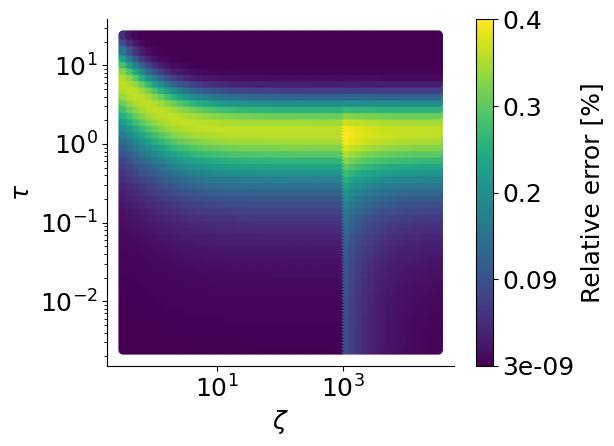

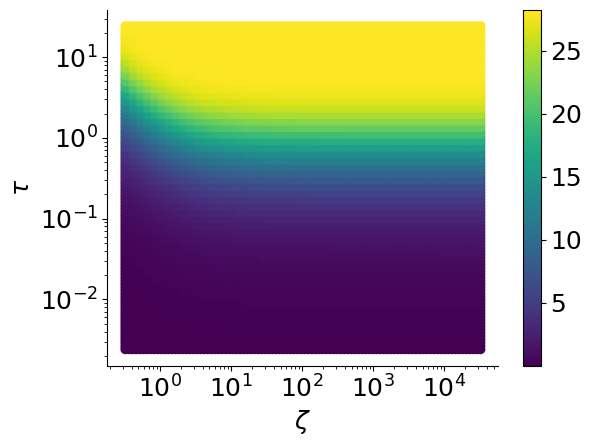

In [5]:
d_hyd=25.4E-3
D_s_vec=np.logspace(-9,-4,N_vec)
L_vec=np.logspace(-0,4,N_vec)
# D_s_vec=np.logspace(-6,-4,5)
# L_vec=np.logspace(3,4,5)
Zeta_v=np.array([])
tau_v=np.array([])
res_vec=np.array([])
eff_v=np.array([])
for j,L in enumerate(L_vec):
        T=800
        for D_s in D_s_vec:
                mat=materials.Flibe(T)
                flibe=Fluid(T=T, Solubility=mat.Solubility, MS=False,D=1E-9, d_Hyd=d_hyd ,mu=mat.mu,rho=mat.rho,U0=1,k=mat.k,
                    cp=mat.cp)
                geom_PAV=Geometry(L=L,D=d_hyd,thick=2.1E-3,n_pipes=1)
                c0=1E-2
                Steel = Membrane( T=T,
                        D=D_s,
                        thick=2.1E-3,
                        K_S=4.41E-3,
                        k_d=1E6,
                        k_r=1E6,k=21)
                PAV = Component(c_in=c0, geometry=geom_PAV,eff=0.5, fluid=flibe, membrane=Steel,p_out=250)
                PAV.fluid.k_t=None
                PAV.get_adimensionals()
                PAV.get_efficiency(plotvar=False,p_out=PAV.p_out)
                PAV.analytical_efficiency(p_out=PAV.p_out)
                out_flux=(PAV.c_in*(1-PAV.eff)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                eff_v=np.append(eff_v, PAV.eff_an*100)
                res_vec=np.append(res_vec, abs(PAV.eff-PAV.eff_an)/PAV.eff_an)
                Zeta_v=np.append(Zeta_v, PAV.zeta)
                tau_v=np.append(tau_v, PAV.tau)
                
                # print("Xi: ", PAV.xi, "Tau: ", PAV.tau, "Efficiency: ", PAV.eff, "Analytical Efficiency: ", PAV.eff_an, "Residual: ", abs(PAV.eff-PAV.eff_an)/PAV.eff_an)
                ## delete flibe steel geom and PAV
                del flibe
                del Steel
                del geom_PAV
                del PAV
plt.figure(1)
plt.yscale('log')
plt.xscale('log')
x = np.logspace(np.log10(min(Zeta_v[:])), np.log10(max(Zeta_v[:])), num=100)
y = np.logspace(np.log10(min(tau_v[:])), np.log10(max(tau_v[:])), num=100)
X, Y = np.meshgrid(x, y)
Z = griddata((Zeta_v, tau_v), (res_vec)*100, (X, Y), method='nearest')
Z_eff=griddata((Zeta_v, tau_v), eff_v, (X, Y), method='nearest')
scatter=plt.scatter(X,Y, c=Z ) 
if scatter:
        if np.nanmin(scatter.get_array()) < np.nanmax(scatter.get_array()):
                cbar = plt.colorbar(scatter, norm=colors.LogNorm(vmin=1E-4, vmax=np.max(res_vec)))  # Show color scale for scatter
                # cbar.set_ticks([1E-4, 1E-3, 1E-2, 1E-1])
                # cbar.set_ticklabels(['1E-4', '1E-3', '1E-2', '1E-1'])
                tick_values = np.linspace(res_vec.min()*100, res_vec.max()*100, 5)
                cbar.set_ticks(tick_values)
                cbar.set_label('Relative error [%]')

                # Set tick labels with 1 significant figure
                cbar.set_ticklabels([f"{val:.1g}" for val in tick_values])
        else:
                print("Cannot create colorbar: data does not have a valid range of values.")
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$\tau$')
plt.gca().spines['right'].set_visible(False)   
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('PAV_rel_error_LM_pout.png', dpi=300)      
plt.show()
plt.figure(2)
plt.yscale('log')
plt.xscale('log')
scatter=plt.scatter(X,Y, c=Z_eff )
if scatter:
        if np.nanmin(scatter.get_array()) < np.nanmax(scatter.get_array()):
                plt.colorbar(scatter)  # Show color scale for scatter
                tick_values = np.linspace(eff_v.min(), eff_v.max(), 5)
                cbar.set_ticks(tick_values)

                # Set tick labels with 1 significant figure
                cbar.set_ticklabels([f"{val:.3g}" for val in tick_values])
                cbar.set_label('Extraction efficiency [%]')
        else:
                print("Cannot create colorbar: data does not have a valid range of values.")
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$\tau$')
plt.gca().spines['right'].set_visible(False)   
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('PAV_eff_LM_pout.png', dpi=300)     

Plots indicate very low relative error between the methods. Discontinuites in the plot indicate different if branches in the axial method (eg: fluid/diffusion>1000 in the solubility sweep), or different techniques to evaluate Sherwood (based on Reynolds number)